In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import spatial

## Load and concat CSVs

In [4]:
user = (
    'cgusb' if 'cgusb' in [f.stem for f in Path(r"C:\Users").iterdir()]
    else 'gusb'
)

range_keys = [
    (50, 249),
    (250, 449),
    (450, 650),
    (640, 850),
    (840, 1050),
]

dir_path = Path(fr"C:\Users\{user}\Research\mhe-analysis\data\IDOX_prill_1")
path_concat = Path(dir_path) / 'IDOX_prill_1_concat.csv'
if not path_concat.exists():
    print('Creating concatenated CSV...')
    # Iterate through CSVs and load into DataFrames
    paths = {}
    dfs = []
    lengths = []
    for i in range(len(range_keys)):
        paths[range_keys[i]] = (
            Path(dir_path) / r"IDOXprill_1_IDOXpucks_voidThreshold_"
            fr"{range_keys[i][0]}-{range_keys[i][1]}_properties.csv"
        )
        df = pd.read_csv(paths[range_keys[i]])
        df.insert(0, 'range_0', [range_keys[i][0]]*df.shape[0])
        df.insert(1, 'range_1', [range_keys[i][1]]*df.shape[0])
        dfs.append(df)
        lengths.append(df.shape[0])
    # Concatenate multiple CSVs into a single CSV
    df = pd.concat(dfs)
    assert df.shape[0] == sum(lengths)
    print('Number of total entries:', df.shape[0])
    # Split centroid column of lists into three separate columns
    df_centroids = pd.DataFrame(
        df.centroid.str.split(', ').tolist(),
        columns=['centroid_x', 'centroid_y', 'centroid_z']
    )
    for i, label in enumerate(['x', 'y', 'z']):
        df.insert(5+i, f'centroid_{label}', df_centroids[f'centroid_{label}'])
    # Save concat DataFrame as CSV
    df.to_csv(path_concat, index=False)
else:
    print('Loading concatenated CSV...')
    df = pd.read_csv(path_concat)
    print('Number of rows:', df.shape[0])
df.head()

Loading concatenated CSV...
Number of rows: 195123


,range_0,range_1,particleID,n_voxels,n_voxels_post_erosion,centroid_x,centroid_y,centroid_z,centroid,slice_min,...,col_max,meshed,stl_x_min,stl_x_max,stl_y_min,stl_y_max,stl_z_min,stl_z_max,stl_is_watertight,stl_volume
0,50,249,2,14494.0,NaN,883,537,6,"883, 537, 6",0,...,908,True,699.87537,735.53780,417.00740,458.34338,40.120243,62.004013,True,7687.004387
1,50,249,3,14015.0,NaN,962,536,9,"962, 536, 9",0,...,985,True,767.14770,797.94710,418.62842,457.53290,40.120243,62.814520,True,7436.799888
2,50,249,4,271480.0,NaN,815,568,18,"815, 568, 18",0,...,898,True,596.13007,727.43270,408.90228,506.16348,40.120243,82.266760,True,144439.379941
3,50,249,5,982.0,NaN,931,575,4,"931, 575, 4",0,...,939,True,747.69543,760.66364,458.34338,475.36410,40.120243,49.846363,True,514.142512
4,50,249,6,477492.0,NaN,975,605,24,"975, 605, 24",0,...,1055,True,734.72730,854.68280,438.08066,556.41510,40.120243,96.855940,True,254113.304870


## Create Delaunay Triangulation

In [5]:
# Pull points from DataFrame
points = np.zeros((df.shape[0], 3))
points[:, 0] = df.centroid_x
points[:, 1] = df.centroid_y
points[:, 2] = df.centroid_z
# Compute Delaunay triangulation
tri = spatial.Delaunay(points)
# Extract edges from simplices and create NetworkX graph
G = nx.Graph()
for simplex in tri.simplices:
    # Add edges for each pair of vertices in the simplex
    G.add_edge(simplex[0], simplex[1])
    G.add_edge(simplex[1], simplex[2])
    G.add_edge(simplex[2], simplex[0])
# Add node positions for drawing
pos = {i: points[i] for i in range(len(points))}

In [6]:
points.shape

(195123, 3)

In [14]:
[*points[:5, :].T]

[array([883., 962., 815., 931., 975.]),
 array([537., 536., 568., 575., 605.]),
 array([ 6.,  9., 18.,  4., 24.])]

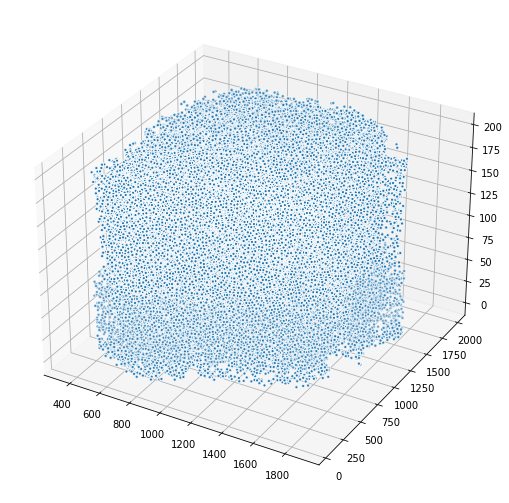

In [ ]:
# Create the 3D figure
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection="3d")
# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*points.T, s=10, ec="w")
plt.show()

In [ ]:
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=10, ec="w")
plt.show()